## Quantum Hadamard Walk Simulation

1. Create quantum register `q[0 to num_qubits - 1]`       ← `q[0]` is the **coin qubit**
2. Create classical register `c[0 to num_qubits - 1]`
3. Initialize quantum circuit `qc` with `q` and `c`

4. Apply `X` gate to `q[num_steps + 1]`                   ← Set center position to `|1⟩`

5. For `block` in `1` to `num_steps`:

    a. Apply `H` gate to `q[0]`                            ← Hadamard coin flip

    b. For `s` in `0` to `block - 1`:                      ← Left shift using `CSWAP`<br>
    1.   `left  ← q[num_steps - block + 2*s + 1]`<br>
    2.  `right ← q[num_steps - block + 2*s + 2]`<br>
    3. `Apply CSWAP(q[0], left, right)`<br>

    c. Apply `X` gate to `q[0]`                            ← Flip coin direction

    d. For `s` in `0` to `block - 1`:                      ← Right shift using `CSWAP`<br>
    1.  ` left  ← q[num_steps - block + 2*s + 2]`<br>
    2.  `right ← q[num_steps - block + 2*s + 3]`<br>
    3. `Apply CSWAP(q[0], left, right)`

    e. Apply `X` gate to `q[0]`                            ← Flip coin back

6. For `m` in `1` to `num_qubits - 1`:
    - Measure `q[m]` into `c[m-1]`                           ← Skip coin qubit

7. Return the quantum circuit `qc`



Measurement Probabilities:
  State |00000010000>: 0.1198
  State |00100000000>: 0.5367
  State |00000000001>: 0.0273
  State |00001000000>: 0.1292
  State |00000000100>: 0.1537
  State |10000000000>: 0.0333


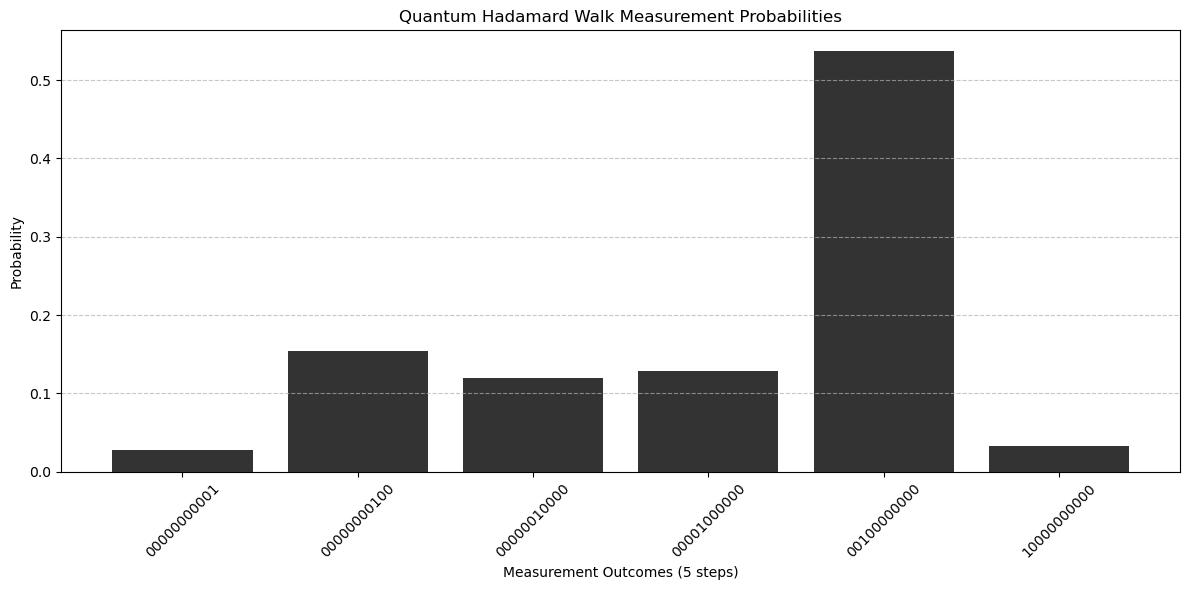

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np


def build_hadamard_walk_circuit(num_steps: int) -> QuantumCircuit:
    """
    Builds a quantum Hadamard walk circuit using Hadamard, CSWAP, and CX (via X gates).

    Parameters:
        num_steps (int): Number of steps in the quantum walk.

    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    num_qubits = 2 * num_steps + 2
    q = QuantumRegister(num_qubits, 'q')
    c = ClassicalRegister(num_qubits-1, 'c')
    qc = QuantumCircuit(q, c)

    # Initialize central position qubit to |1⟩
    qc.x(q[num_steps + 1])

    # Walk through blocks
    for block in range(1, num_steps + 1):
        qc.h(q[0])  # Hadamard coin

        # Left shift swaps
        for s in range(block):
            qc.cswap(q[0], q[num_steps - block + 2 * s + 1], q[num_steps - block + 2 * s + 2])

        qc.x(q[0])  # Flip coin direction

        # Right shift swaps
        for s in range(block):
            qc.cswap(q[0], q[num_steps - block + 2 * s + 2], q[num_steps - block + 2 * s + 3])

        qc.x(q[0])  # Flip coin back

    # Measurements on all position qubits except q[0] (coin)
    for m in range(1, num_qubits):
        qc.measure(q[m], c[m-1])

    return qc


def run_simulation(qc: QuantumCircuit, shots: int = 10000) -> dict:
    """
    Runs the quantum circuit simulation.

    Parameters:
        qc (QuantumCircuit): Circuit to simulate.
        shots (int): Number of shots.

    Returns:
        dict: Counts from the simulation.
    """
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=shots).result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict) -> dict:
    """
    Converts raw counts into normalized probabilities.

    Parameters:
        counts (dict): Measurement counts.

    Returns:
        dict: Normalized probability distribution.
    """
    total = sum(counts.values())
    return {state: count / total for state, count in counts.items()}


def plot_probabilities(probabilities: dict, num_steps: int):
    """
    Plots sorted probability distribution.

    Parameters:
        probabilities (dict): State probabilities.
        num_qubits (int): Total number of qubits (for label formatting).
    """
    if not probabilities:
        print("No measurement outcomes to plot.")
        return

    # Sort binary outcomes numerically
    sorted_states = sorted(probabilities.keys(), key=lambda x: int(x, 2))
    sorted_probs = [probabilities[state] for state in sorted_states]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_states, sorted_probs, color='black', alpha=0.8)
    plt.xlabel(f"Measurement Outcomes ({num_steps} steps)")
    plt.ylabel("Probability")
    plt.title("Quantum Hadamard Walk Measurement Probabilities")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def main(num_steps=5, shots=10000):
    """
    Main function to build, simulate, and visualize the Hadamard quantum walk.

    Parameters:
        num_steps (int): Number of steps in the quantum walk.
        shots (int): Number of shots for simulation.
    """
    num_qubits = 2 * num_steps + 2
    qc = build_hadamard_walk_circuit(num_steps)
    counts = run_simulation(qc, shots)
    probabilities = calculate_probabilities(counts)

    print("\nMeasurement Probabilities:")
    for state, prob in probabilities.items():
        print(f"  State |{state}>: {prob:.4f}")

    plot_probabilities(probabilities, num_steps)
    qc.draw('mpl')  # Optionally show circuit diagram


if __name__ == "__main__":
    main()
